In [1]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv('data/clean/clean_dataset_posBERTV1.csv')
df.head()

,name,multiCorpus_noun,name_length,multiCorpus_noun_rm10,multiCorpus_noun_rm20,multiCorpus_noun_rm30,multiCorpus_noun_rm40
0,Gamis Pria Dewasa Premium / Jubah Pakistan Polos,pria premium jubah pakistan,12,pria premium,pria premium,pria premium,pria premium
1,Buket Bunga Mawar Flanel / Bunga wisuda / Bung...,buket bunga mawar flanel bunga wisuda bunga so...,17,buket bunga mawar bunga wisuda bunga souvenir,bunga bunga bunga souvenir,bunga bunga bunga,bunga bunga bunga
2,Mika Sen Depan Supra Fit New Kaca Lampu Sein D...,mika depan fit new kaca lampu dpn motor bebek,20,mika fit new kaca lampu motor bebek,fit new kaca lampu motor bebek,new kaca lampu motor,new kaca lampu motor
3,Blazer wanita jumbo big size stik balik / plus...,blazer wanita jumbo size plus size,22,blazer wanita jumbo size size,blazer wanita jumbo size size,wanita jumbo size size,wanita jumbo size size
4,Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...,buku ilmu sosial budaya kesadaran,4,buku ilmu sosial,buku,buku,buku


In [3]:
# List min_df dan range klaster
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
vectorizers = {
    'original noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun']),
    'noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm10']),
    'noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm20']),
    'noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm30']),
    'noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm40'])
}
results = []  # List untuk menyimpan hasil eksperimen

In [4]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(range_list):
    for name, data in vectorizers.items():
        for cluster_range in range_list:
            silhouette_scores = []
            for n_clusters in cluster_range:
                # K-Means clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # Simpan hasil eksperimen
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# Jalankan eksperimen
clustering_experiment(range_list)

In [5]:
results_df = pd.DataFrame(results)

In [6]:
results_df.head()

,model_noun,cluster_range,avg_silhouette_score,best_silhouette_score
0,original noun,2-19,0.005756,0.009072
1,original noun,100-119,0.021743,0.022147
2,original noun,500-519,0.036259,0.036492
3,original noun,1000-1019,0.045718,0.045828
4,noun remove-10,2-19,0.015015,0.023896


C:\Users\User\AppData\Local\Temp\ipykernel_22568\3527163273.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


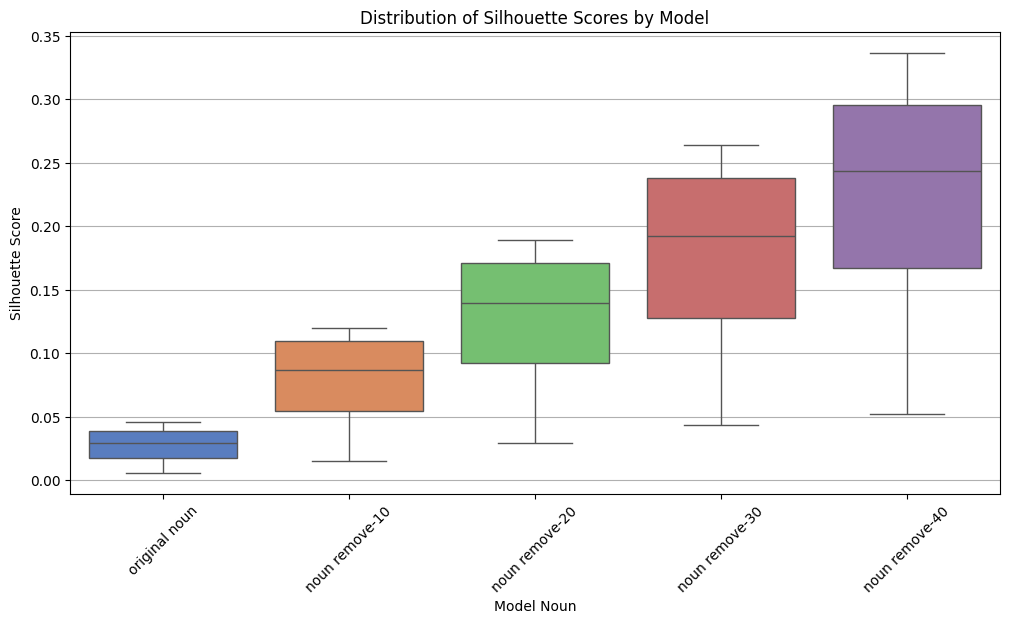

In [7]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


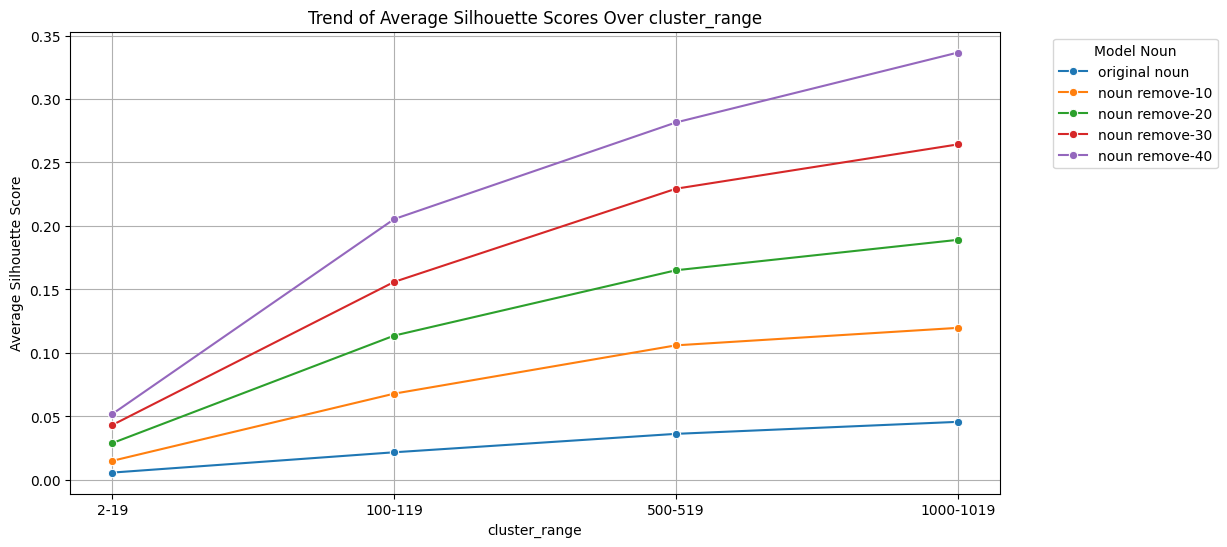

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


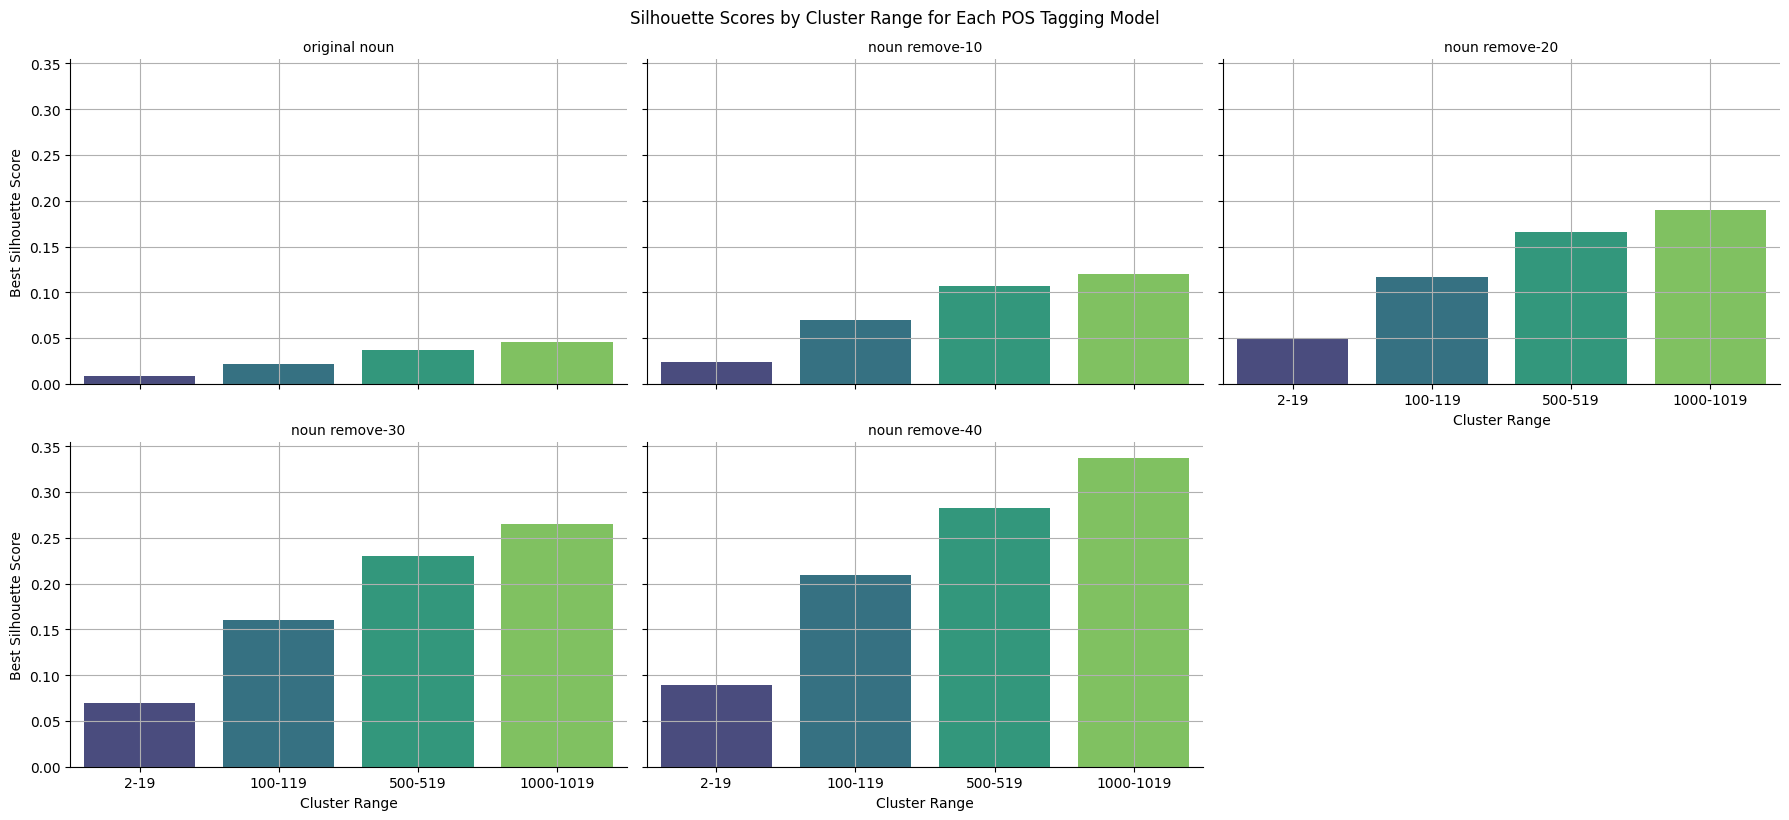

In [9]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

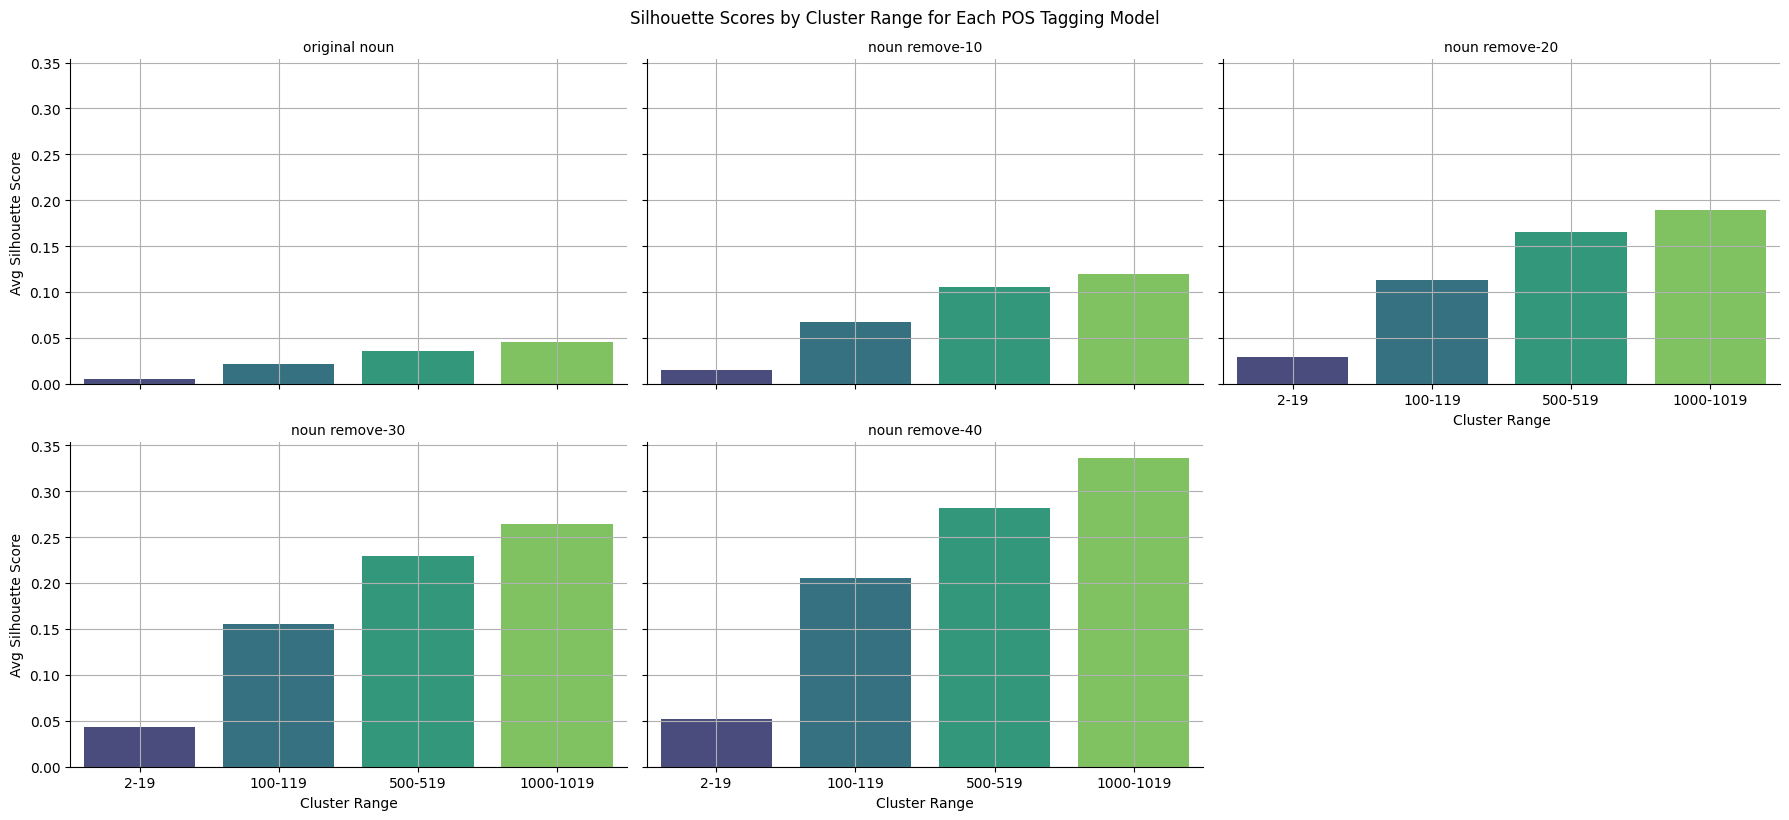

In [10]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# CLEAN VERSION

In [11]:
df1 = pd.read_csv('data/clean/clean_dataset_posBERTV1-1.csv')
df1.head()

,name,multiCorpus_noun,name_length,multiCorpus_noun_rm10,multiCorpus_noun_rm20,multiCorpus_noun_rm30,multiCorpus_noun_rm40
0,Gamis Pria Dewasa Premium / Jubah Pakistan Polos,pria jubah pakistan,4,pria,pria,pria,pria
1,Buket Bunga Mawar Flanel / Bunga wisuda / Bung...,buket bunga mawar flanel bunga wisuda bunga so...,17,buket bunga mawar bunga wisuda bunga souvenir,bunga bunga bunga souvenir,bunga bunga bunga,bunga bunga bunga
2,Mika Sen Depan Supra Fit New Kaca Lampu Sein D...,mika depan fit kaca lampu dpn motor bebek,16,mika fit kaca lampu motor bebek,fit kaca lampu motor bebek,kaca lampu motor,kaca lampu motor
3,Blazer wanita jumbo big size stik balik / plus...,blazer wanita jumbo plus,12,blazer wanita jumbo,blazer wanita jumbo,wanita jumbo,wanita jumbo
4,Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...,buku ilmu sosial budaya kesadaran,4,buku ilmu sosial,buku,buku,buku


In [16]:
# List min_df dan range klaster
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
vectorizers = {
    'original noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun']),
    'noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm10']),
    'noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm20']),
    'noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm30']),
    'noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm40'])
}
results1 = []  # List untuk menyimpan hasil eksperimen

In [17]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(range_list, results):

    for name, data in vectorizers.items():
        for cluster_range in range_list:
            silhouette_scores = []
            for n_clusters in cluster_range:
                # K-Means clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # Simpan hasil eksperimen
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# Jalankan eksperimen
clustering_experiment(range_list, results1)

In [18]:
results_df1 = pd.DataFrame(results1)

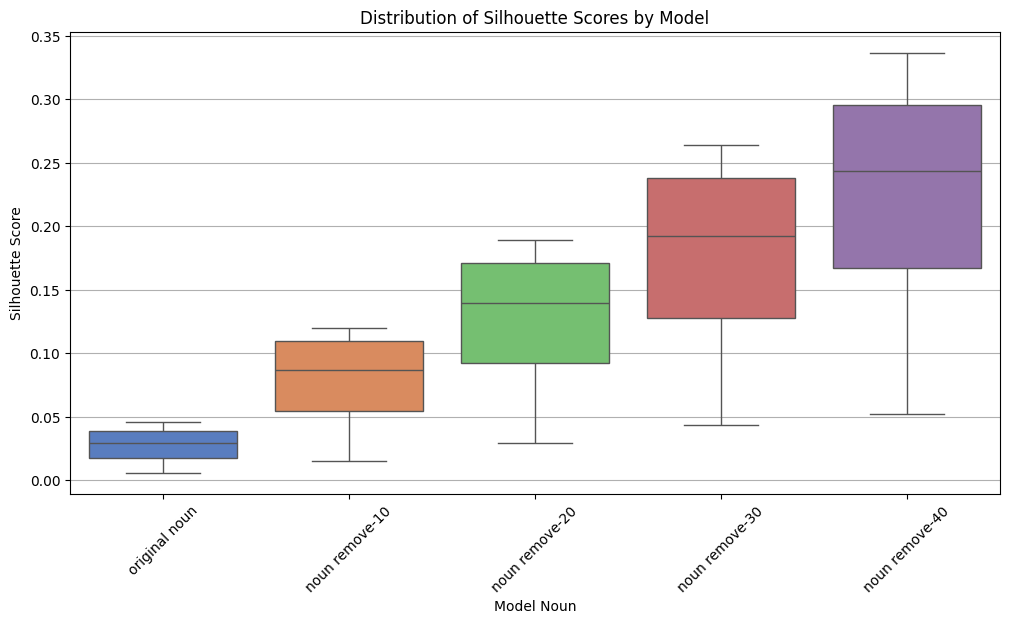

In [20]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df1,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='model_noun'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


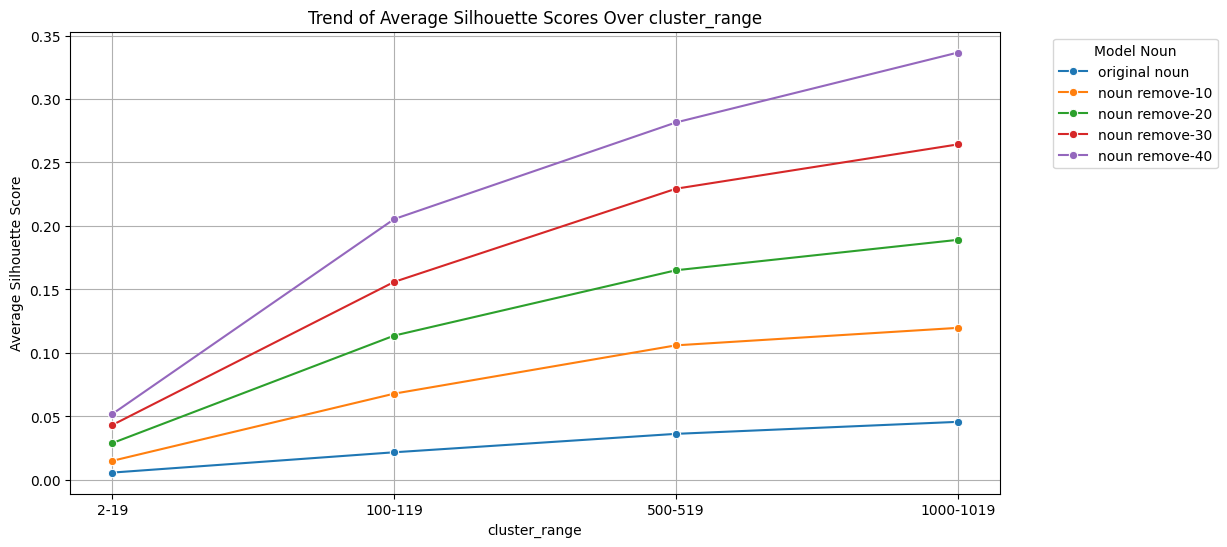

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df1,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


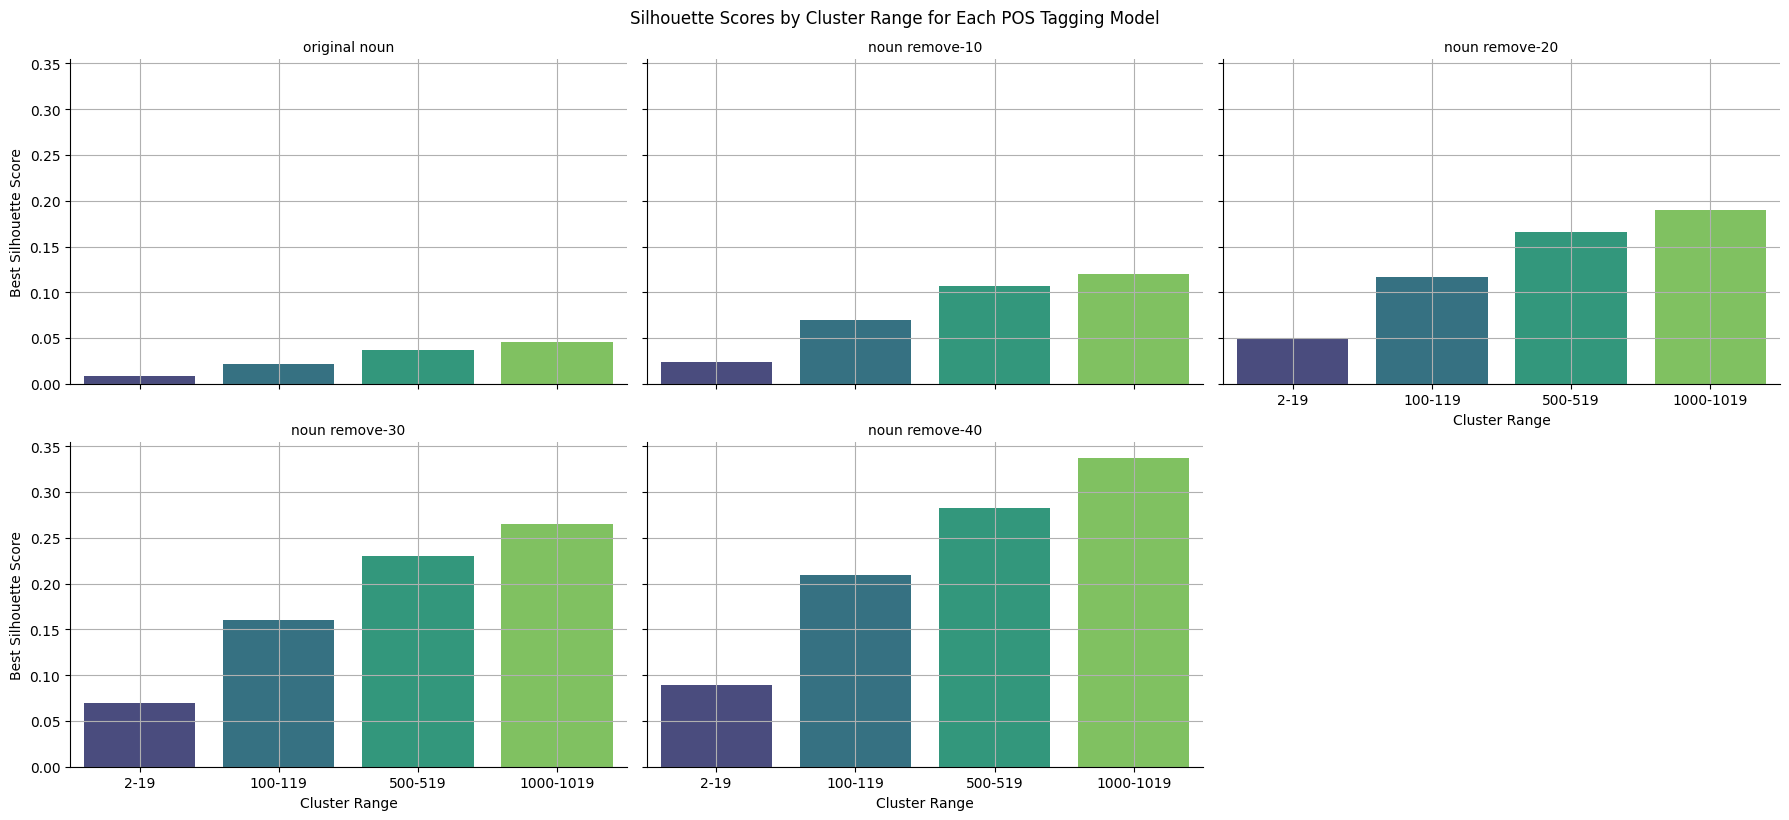

In [23]:
g = sns.FacetGrid(
    results_df1,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue
                ="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

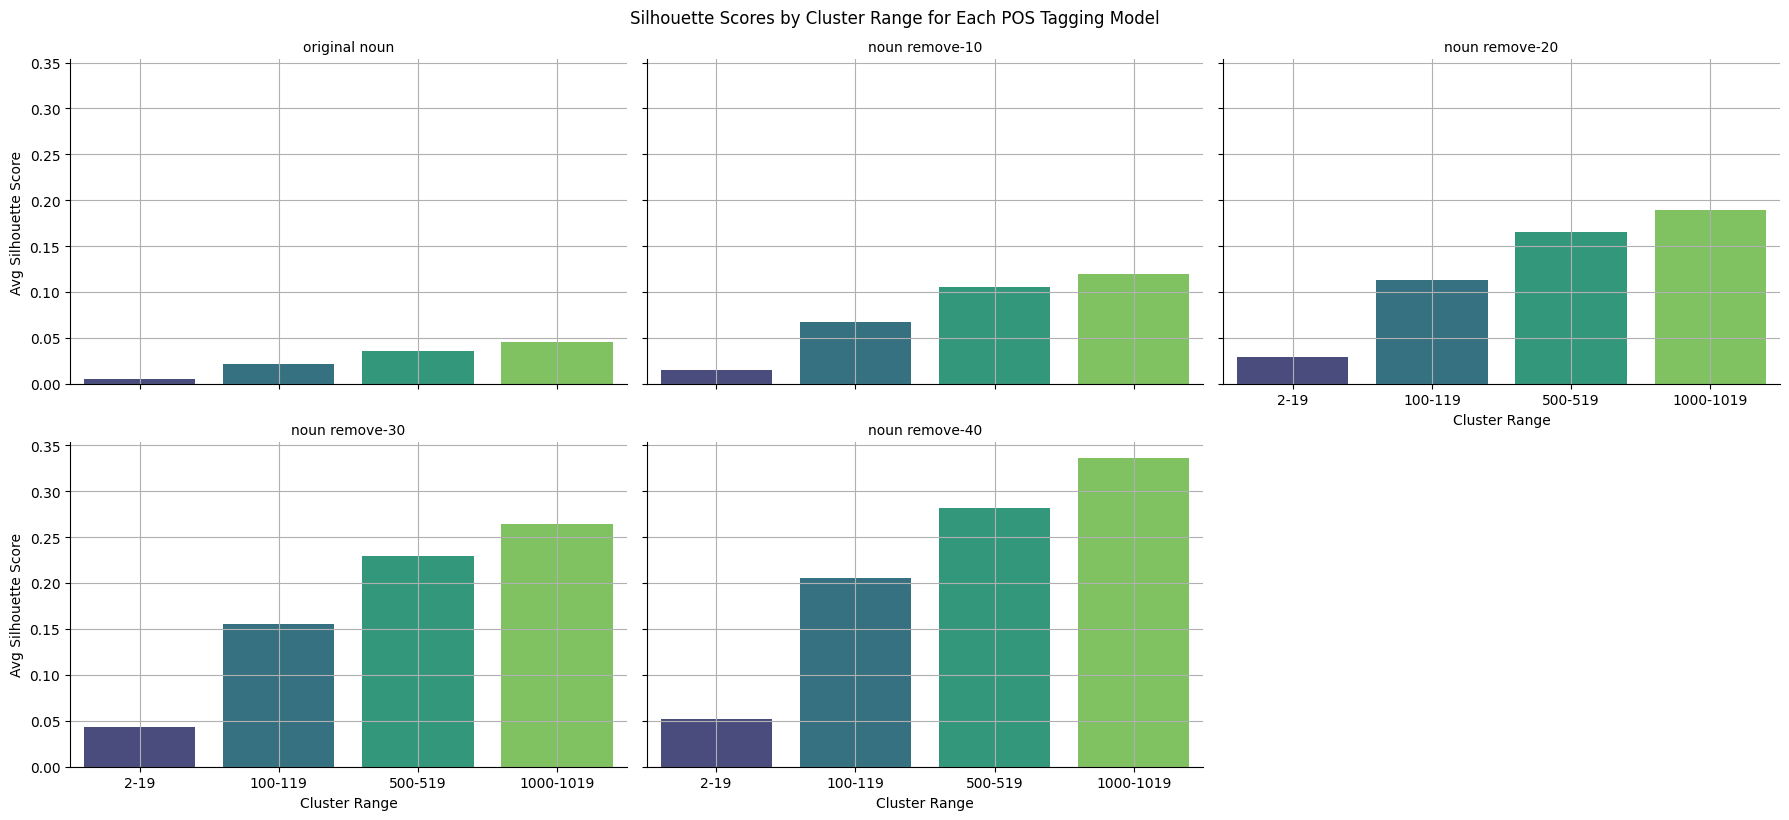

In [24]:
g = sns.FacetGrid(
    results_df1,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()